In [1]:
!pip install phik

In [1]:
!pip install sentence-transformers

In [2]:
import pandas as pd
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
import numpy as np
import re
from scipy import stats
import phik

from transformers import BertTokenizer, BertModel
import torch
from scipy.spatial.distance import cosine
from pathlib import Path
import pandas as pd

from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

import sys
import os
sys.path.append(os.path.join(sys.path[0], '../src'))
import data_preprocessing 

from tqdm import tqdm

In [3]:
sns.set_style("whitegrid")

In [4]:
BASE_DIR = Path('result_analysis.ipynb').resolve().parent.parent
DATA_DIR = BASE_DIR.joinpath('data/results')

### Initial Dataset

In [5]:
DATASETS_NAME = "datasets_name.csv"
DATASETS_DIR = BASE_DIR.joinpath('data/datasets')
DATASETS_NAME = DATASETS_DIR.joinpath(DATASETS_NAME)
datasets_name = pd.read_csv(
    DATASETS_NAME, 
    sep=",", 
    header=0
)

datasets_name

,INPUT:wordset,INPUT:dataset_name,ASSIGNMENT:worker_id
0,able amaze fill glad stop daily fantastic move...,amazon_food,3
1,able amaze fill stop glad daily fantastic move...,amazon_food,12
2,able amaze fill stop glad daily fantastic move...,amazon_food,3
3,able amaze glad fill stop fantastic daily move...,amazon_food,3
4,absolute church truth doug scripture symbol li...,20newsgroups,5
...,...,...,...
3856,year two size old every last month start since...,amazon_food,3
3857,year two size old every last month start week ...,amazon_food,6
3858,year two size old last month every start week ...,amazon_food,3
3859,year work two every size old last month start ...,amazon_food,3


In [6]:
print("Unique dataset:", list(set(datasets_name["INPUT:dataset_name"])))

Unique dataset: ['20newsgroups', 'amazon_food']


In [7]:
# Divide the entire dataset into parts by the dataset name
amazon_food_data = datasets_name[datasets_name["INPUT:dataset_name"]=="amazon_food"]
newsgroups_data = datasets_name[datasets_name["INPUT:dataset_name"]=="20newsgroups"]

amazon_food_texts = amazon_food_data["INPUT:wordset"]
newsgroups_texts = newsgroups_data["INPUT:wordset"]

### Classification

In [8]:
def classific_metrics(true, predict, model_name="", data_type="str"):
    cm = confusion_matrix(true, predict)

    sns.heatmap(cm, 
                annot=True,
                fmt='g', 
                xticklabels=['bad','good'],
                yticklabels=['bad','good'])
    plt.ylabel('Actual',fontsize=13)
    plt.xlabel('Prediction',fontsize=13)
    plt.title(f'Confusion Matrix {model_name}',fontsize=17)
    plt.show()

    print("Accuracy:", round(accuracy_score(true, predict), 3))
    print("F1-score:", round(f1_score(true, predict, pos_label="good"), 3))

    if data_type == "str":
        true = [0 if x=="bad" else 1 for x in true]
        predict = [0 if x=="bad" else 1 for x in predict]
            
    print("Pearson correlaton:", stats.pearsonr(true, predict))


def print_answers_distrib(amazon_data, newsgroups_data, model_name=""):
    fig, axs = plt.subplots(2, 2, figsize=(10,8))

    fig.text(-0.2, 0.5, "Amazon_food", ha='center', va='center', fontsize=16, transform=axs[0, 0].transAxes, rotation="vertical")

    sns.histplot(data=amazon_data, x="true", ax=axs[0,0])
    axs[0,0].set_title("Distribution of the human answers")

    sns.histplot(data=amazon_data, x="model", ax=axs[0,1])
    axs[0,1].set_title(f"Distribution of the {model_name} answers")

    fig.text(-0.2, 0.5, "20newsgroups", ha='center', va='center', fontsize=16, transform=axs[1, 0].transAxes, rotation="vertical")

    sns.histplot(data=newsgroups_data, x="true", ax=axs[1,0])
    axs[1,0].set_title(f"Distribution of the human answers")

    sns.histplot(data=newsgroups_data, x="model", ax=axs[1,1])
    axs[1,1].set_title(f"Distribution of the {model_name} answers")

    plt.tight_layout()

    plt.show()


def plot_phi_corel(amazon_data, newsgroups_data, model_name=""):
    fig, axs = plt.subplots(1, 2, figsize=(12,6))

    fig.suptitle(model_name, fontsize=16)

    # Phi-K
    ph_matrix_amazon = amazon_data.phik_matrix()
    sns.heatmap(
        ph_matrix_amazon, 
        annot=True,
        fmt='g',
        ax=axs[0])
    axs[0].set_title("Amazon Phik correlation coefficient")

    # Phi-K
    ph_matrix_newsgroups = newsgroups_data.phik_matrix()
    sns.heatmap(
        ph_matrix_newsgroups, 
        annot=True,
        fmt='g',
        ax=axs[1])
    axs[1].set_title("20newsgroups Phik correlation coefficient")

    plt.tight_layout()
    plt.show()

In [9]:
def extract_answer(input_string):
    matches = re.findall(r'\b\w*\s*(YES|NO)\s*\w*\b', input_string)
    if len(matches) == 0:
        matches = input_string
    return matches[-1]

In [10]:
PROMPT_MISTRAL_1 = "data_qality_estim_mistral_7b_4bit_type3.csv"
PROMPT_MISTRAL_2 = "data_qality_estim_mistral_7b_4bit_type5.csv"
PROMPT_MISTRAL_3 = "data_qality_estim_mistral_7b_4bit_type6.csv"
PROMPT_LLAMA_1 = "data_qality_estim_llama_13b_4bit_type1.csv"

PROMPT_MISTRAL_1 = DATA_DIR.joinpath(PROMPT_MISTRAL_1)
PROMPT_MISTRAL_2 = DATA_DIR.joinpath(PROMPT_MISTRAL_2)
PROMPT_MISTRAL_3 = DATA_DIR.joinpath(PROMPT_MISTRAL_3)
PROMPT_LLAMA_1 = DATA_DIR.joinpath(PROMPT_LLAMA_1)

data_prompt_mistral_1 = pd.read_csv(PROMPT_MISTRAL_1, sep=";", names=["text", "true", "model"])
data_prompt_mistral_2 = pd.read_csv(PROMPT_MISTRAL_2, sep=";", names=["text", "true", "model"])
data_prompt_mistral_3 = pd.read_csv(PROMPT_MISTRAL_3, sep=";", names=["text", "true", "model"])
data_prompt_llama_1 = pd.read_csv(PROMPT_LLAMA_1, sep=";", names=["text", "true", "model"])

#### Few-shot Mistral TYPE I

You will receive a list of words, and you should answer "YES" or "NO" to the question: "Is it possible to determine a common topic for the presented word set or at least for the most part of the set?"

bike firearm knife criminal carry death weapon scsi murder smith handgun moral child defense tape // YES

appreciate advance anybody info thank experience hello greatly suggestion wonder edge able email recently thanx // NO

bible christ matthew heaven scripture lord father word passage teach mary spirit doctrine verse faith // YES

In [11]:
data_prompt_mistral_1.head(10)

,text,true,model
0,pack variety com www http href stash pie grey ...,bad,NO</s>
1,south island ship secret military rutgers brit...,bad,NO</s>
2,piece beef jerky everything season break pill ...,bad,YES</s>
3,mix cream ice pour strawberry stir pancake waf...,good,NO</s>
4,window display screen color server application...,good,YES</s>
5,magnesium oil olive energy diamond bowel blue ...,good,NO</s>
6,encryption chip clipper security escrow secure...,good,YES</s>
7,dry liver freeze gravy movie walk cube lick st...,bad,NO</s>
8,bone bubble rawh oat gum chewer miso slim chin...,bad,NO</s>
9,year month friend husband gift weight ago lose...,bad,YES</s>


In [12]:
# Clean data
# Remove </s>

data_prompt_mistral_1["model"] = [x.replace("</s>", "") for x in data_prompt_mistral_1["model"]]
data_prompt_mistral_1["model"] = [extract_answer(x) for x in data_prompt_mistral_1["model"]]
data_prompt_mistral_1["model"] = ["bad" if x=="NO" else "good" for x in data_prompt_mistral_1["model"]]

In [13]:
# Divide into two datasets
data_prompt_mistral_1_amazon = data_prompt_mistral_1[data_prompt_mistral_1["text"].isin(amazon_food_texts)]
data_prompt_mistral_1_newsgroups = data_prompt_mistral_1[data_prompt_mistral_1["text"].isin(newsgroups_texts)]

In [14]:
data_prompt_mistral_1_amazon.to_csv(DATA_DIR.joinpath("quality_estim_mistral_7B_type3_amazon.csv"))
data_prompt_mistral_1_newsgroups.to_csv(DATA_DIR.joinpath("quality_estim_mistral_7B_type3_newsgroup.csv"))

In [15]:
data_prompt_mistral_1_amazon

,text,true,model
0,pack variety com www http href stash pie grey ...,bad,bad
2,piece beef jerky everything season break pill ...,bad,good
3,mix cream ice pour strawberry stir pancake waf...,good,bad
5,magnesium oil olive energy diamond bowel blue ...,good,bad
7,dry liver freeze gravy movie walk cube lick st...,bad,bad
...,...,...,...
3852,ingredient honey list label special contain co...,bad,good
3853,say way without though fine think yes still to...,bad,good
3854,without help morning son oatmeal warm result s...,bad,good
3858,delicious small dry hard smaller surprised liv...,bad,bad


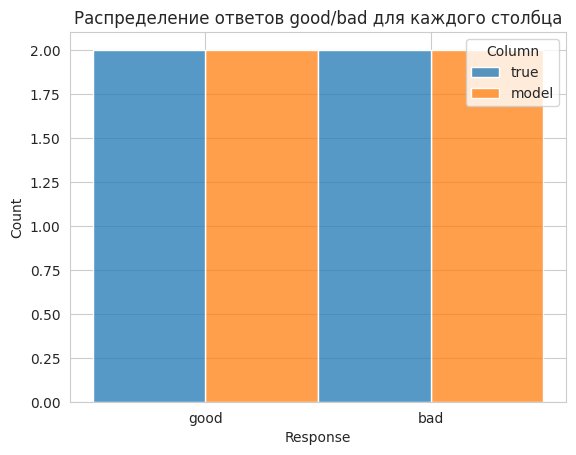

In [18]:
Amazon_food = pd.DataFrame({
    'true': ['good', 'bad', 'good', 'bad'],
    'model': ['good', 'good', 'bad', 'bad']
})

# Переформатирование данных в "long" формат
df_long = Amazon_food.melt(var_name='Column', value_name='Response')

# Создание гистограммы
sns.histplot(data=df_long, x='Response', hue='Column', multiple='dodge')

# Установка заголовка
plt.title('Распределение ответов good/bad для каждого столбца')

# Отображение графика
plt.show()

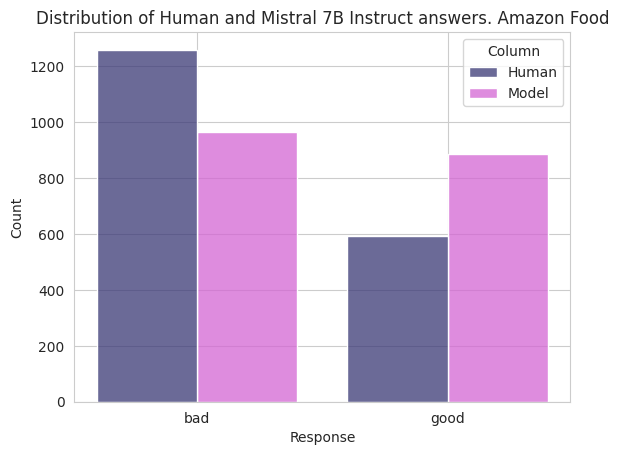

In [33]:
df = data_prompt_mistral_1_amazon[["true", "model"]]
df.columns = ["Human", "Model"]
df_long = df.melt(var_name='Column', value_name='Response')

palette_colors = {"Human": "#3A3875", "Model": "#D366D3"}

sns.histplot(data=df_long, x='Response', hue='Column', multiple='dodge', shrink=0.8, palette=palette_colors)

# Установка заголовка
plt.title('Distribution of Human and Mistral 7B Instruct answers. Amazon Food')

# Отображение графика
plt.show()


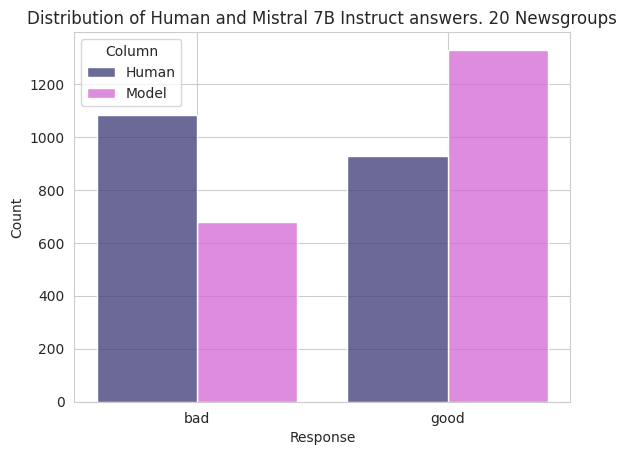

In [34]:
df = data_prompt_mistral_1_newsgroups[["true", "model"]]
df.columns = ["Human", "Model"]
df_long = df.melt(var_name='Column', value_name='Response')

palette_colors = {"Human": "#3A3875", "Model": "#D366D3"}

sns.histplot(data=df_long, x='Response', hue='Column', multiple='dodge', shrink=0.8, palette=palette_colors)

# Установка заголовка
plt.title('Distribution of Human and Mistral 7B Instruct answers. 20 Newsgroups')

# Отображение графика
plt.show()

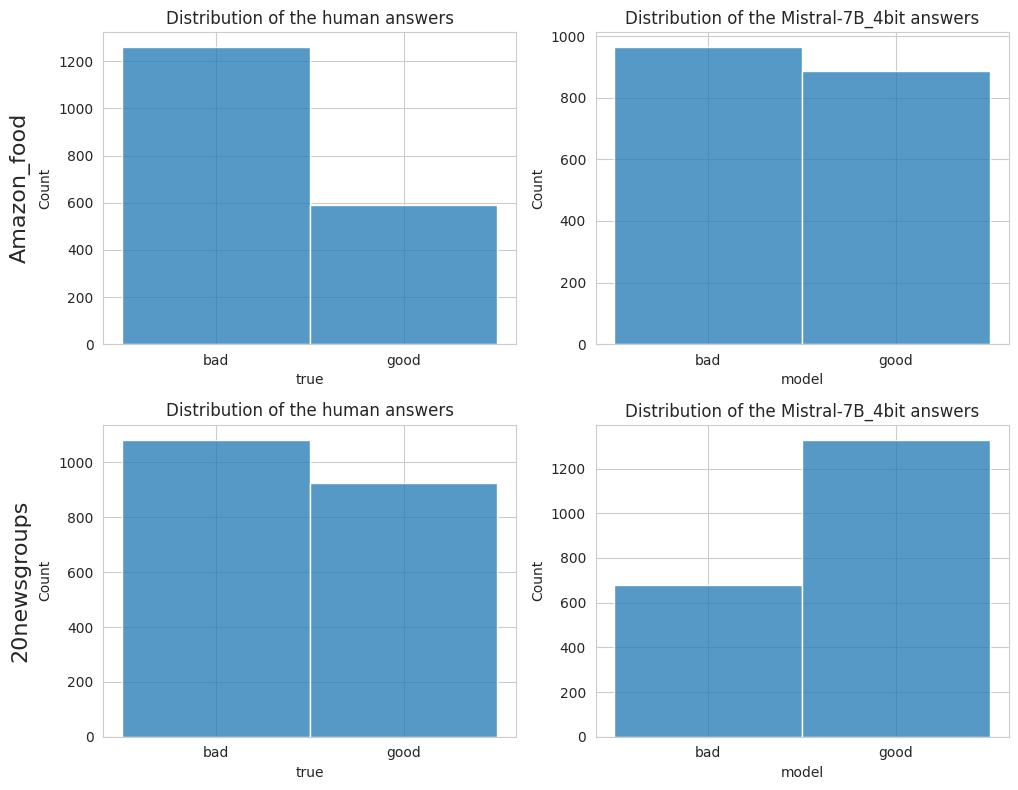

In [16]:
print_answers_distrib(
    data_prompt_mistral_1_amazon,
    data_prompt_mistral_1_newsgroups, 
    model_name="Mistral-7B_4bit"
)

In [19]:
# Analyse texts with None
data_prompt_mistral_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3861 entries, 0 to 3860
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    3861 non-null   object
 1   true    3861 non-null   object
 2   model   3861 non-null   object
dtypes: object(3)
memory usage: 90.6+ KB


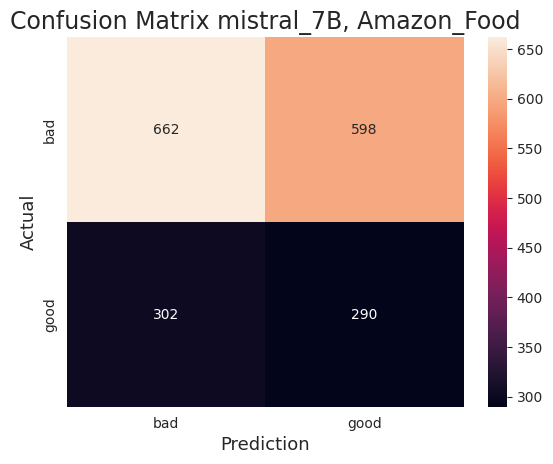

Accuracy: 0.514
F1-score: 0.392
Pearson correlaton: PearsonRResult(statistic=0.014246354971712952, pvalue=0.5400699683135312)


In [20]:
classific_metrics(
    np.array(data_prompt_mistral_1_amazon["true"]), 
    np.array(data_prompt_mistral_1_amazon["model"]), 
    model_name="mistral_7B, Amazon_Food", 
    data_type="str")

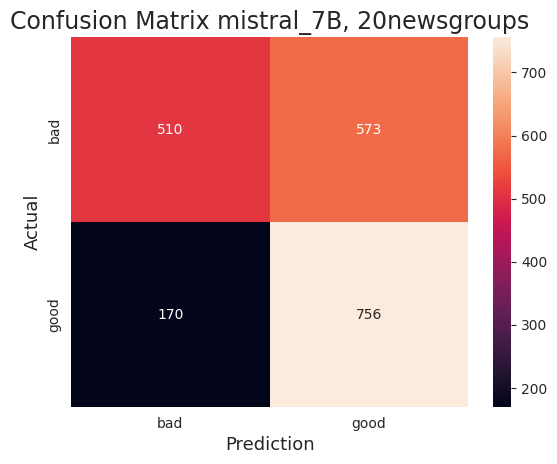

Accuracy: 0.63
F1-score: 0.671
Pearson correlaton: PearsonRResult(statistic=0.30267876650746117, pvalue=7.792600925846337e-44)


In [21]:
classific_metrics(
    np.array(data_prompt_mistral_1_newsgroups["true"]), 
    np.array(data_prompt_mistral_1_newsgroups["model"]), 
    model_name="mistral_7B, 20newsgroups", 
    data_type="str")

/home/alexandra/.pyenv/versions/3.9.7/lib/python3.9/site-packages/phik/data_quality.py:59: UserWarning: The number of unique values of variable text is large: 1852. Are you sure this is not an interval variable? Analysis for pairs of variables including text can be slow.
  warnings.warn(
/home/alexandra/.pyenv/versions/3.9.7/lib/python3.9/site-packages/phik/data_quality.py:59: UserWarning: The number of unique values of variable text is large: 2009. Are you sure this is not an interval variable? Analysis for pairs of variables including text can be slow.
  warnings.warn(


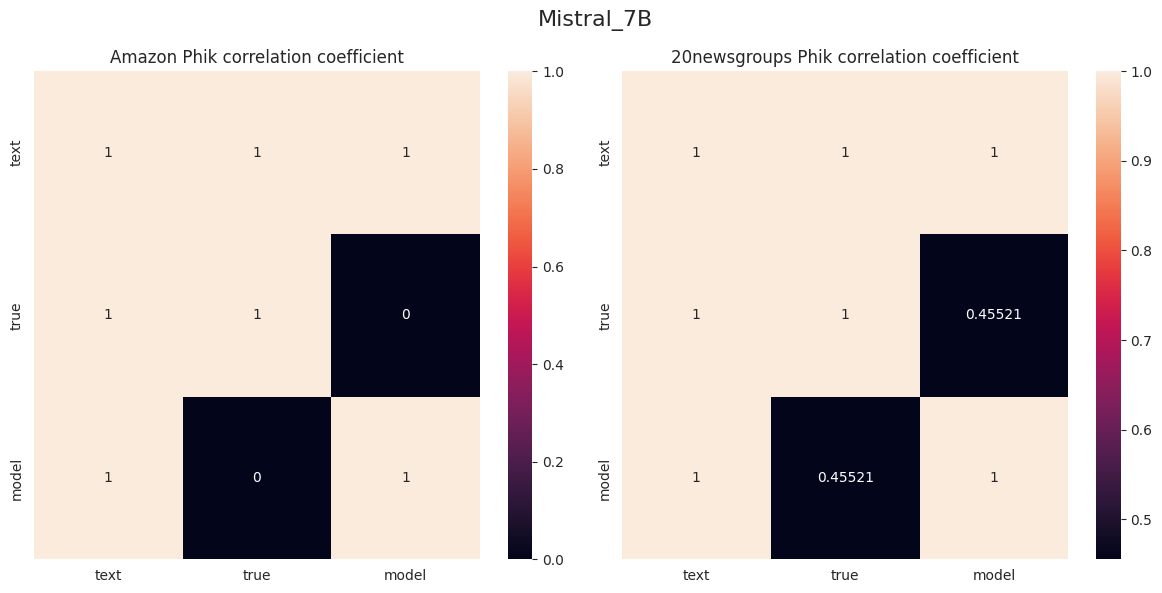

In [22]:
plot_phi_corel(
    data_prompt_mistral_1_amazon, 
    data_prompt_mistral_1_newsgroups, 
    model_name="Mistral_7B"
)

#### Few-shot Mistral TYPE II

Select one of two categories-characteristics of the provided set of tokens by answering the question ”Is it possible to determine a common topic for the presented word set or at least for the most part of the set?”.
You could answer one of the following: YES - if you agree with the statement and words have a strong connection between them, NO - when words seem to be unconnected. Please, make sure you to only return YES or NO and nothing more.

bike firearm knife criminal carry death weapon scsi murder smith handgun moral child defense tape // YES

appreciate advance anybody info thank experience hello greatly suggestion wonder edge able email recently thanx // NO

bible christ matthew heaven scripture lord father word passage teach mary spirit doctrine verse faith // YES

In [28]:
data_prompt_mistral_2

,text,true,model
0,pack variety com www http href stash pie grey ...,bad,YES</s>
1,south island ship secret military rutgers brit...,bad,YES</s>
2,piece beef jerky everything season break pill ...,bad,YES</s>
3,mix cream ice pour strawberry stir pancake waf...,good,YES</s>
4,window display screen color server application...,good,YES</s>
...,...,...,...
3856,engine model rocket band lock foot exhaust pre...,good,YES</s>
3857,font print character page printer vice cell bi...,good,YES</s>
3858,delicious small dry hard smaller surprised liv...,bad,YES</s>
3859,thought end else stick cover boil air china bu...,bad,YES</s>


In [37]:
# Clean data
# Remove </s>

data_prompt_mistral_2["model"] = [x.replace("</s>", "") for x in data_prompt_mistral_2["model"]]
data_prompt_mistral_2["model"] = [x.replace(".", "").strip() for x in data_prompt_mistral_2["model"]]
data_prompt_mistral_2["model"] = ["bad" if x=="NO" else "good" for x in data_prompt_mistral_2["model"]]

In [38]:
# Divide into two datasets
data_prompt_mistral_2_amazon = data_prompt_mistral_2[data_prompt_mistral_2["text"].isin(amazon_food_texts)]
data_prompt_mistral_2_newsgroups = data_prompt_mistral_2[data_prompt_mistral_2["text"].isin(newsgroups_texts)]

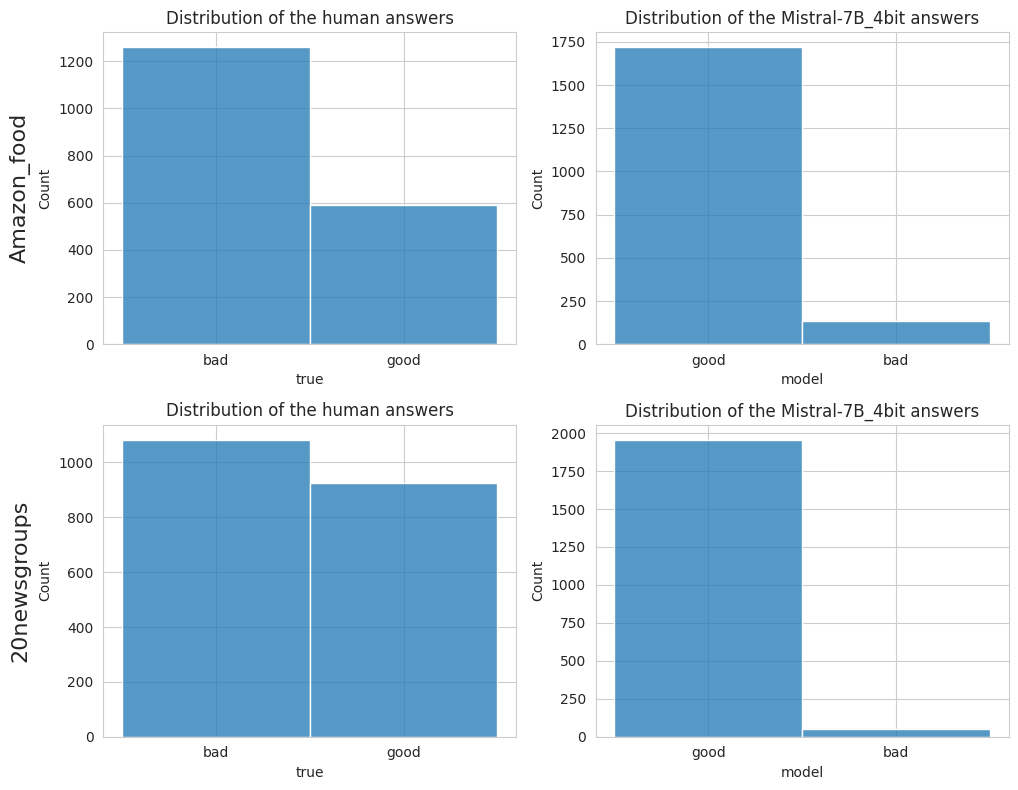

In [39]:
print_answers_distrib(
    data_prompt_mistral_2_amazon,
    data_prompt_mistral_2_newsgroups, 
    model_name="Mistral-7B_4bit"
)

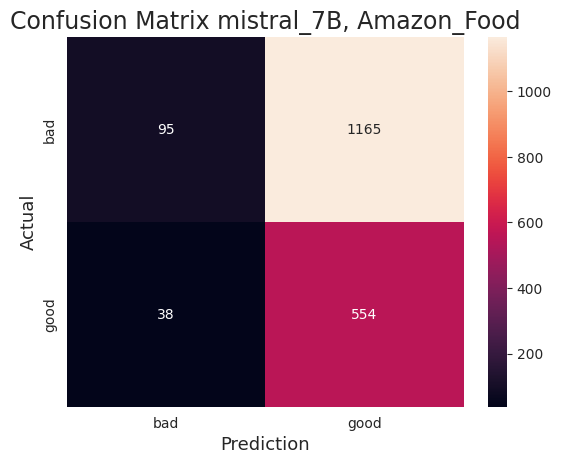

Accuracy: 0.35
F1-score: 0.479
Pearson correlaton: PearsonRResult(statistic=0.02024400298582795, pvalue=0.3839184940039022)


In [40]:
classific_metrics(
    np.array(data_prompt_mistral_2_amazon["true"]), 
    np.array(data_prompt_mistral_2_amazon["model"]), 
    model_name="mistral_7B, Amazon_Food", 
    data_type="str")

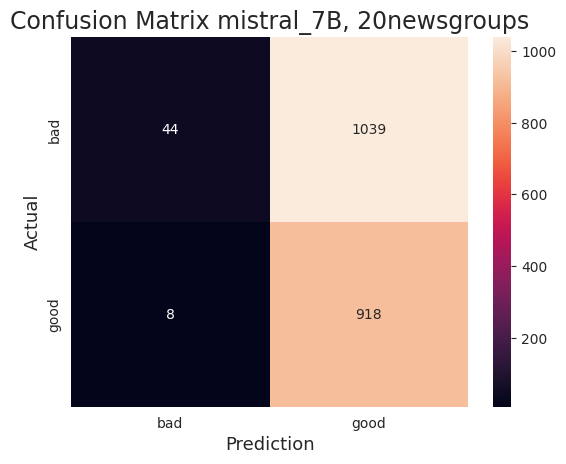

Accuracy: 0.479
F1-score: 0.637
Pearson correlaton: PearsonRResult(statistic=0.10041938408020659, pvalue=6.4954244651904255e-06)


In [41]:
classific_metrics(
    np.array(data_prompt_mistral_2_newsgroups["true"]), 
    np.array(data_prompt_mistral_2_newsgroups["model"]), 
    model_name="mistral_7B, 20newsgroups", 
    data_type="str")

/home/alexandra/.pyenv/versions/3.9.7/lib/python3.9/site-packages/phik/data_quality.py:59: UserWarning: The number of unique values of variable text is large: 1852. Are you sure this is not an interval variable? Analysis for pairs of variables including text can be slow.
  warnings.warn(
/home/alexandra/.pyenv/versions/3.9.7/lib/python3.9/site-packages/phik/data_quality.py:59: UserWarning: The number of unique values of variable text is large: 2009. Are you sure this is not an interval variable? Analysis for pairs of variables including text can be slow.
  warnings.warn(


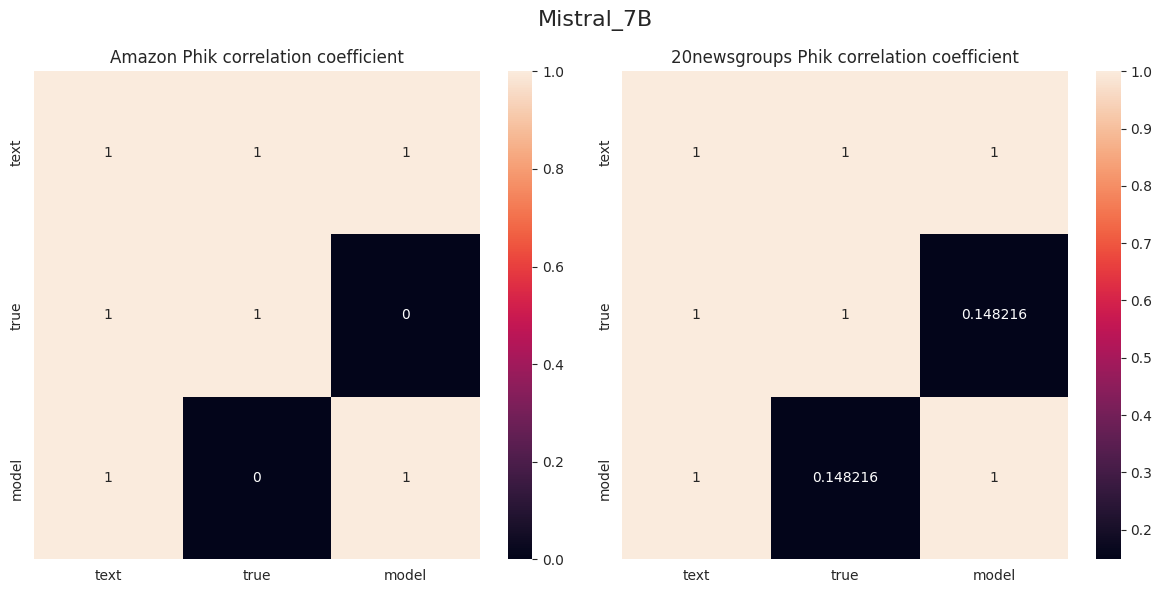

In [42]:
plot_phi_corel(
    data_prompt_mistral_2_amazon, 
    data_prompt_mistral_2_newsgroups, 
    model_name="Mistral_7B"
)

In [43]:
data_prompt_mistral_2_amazon.to_csv(DATA_DIR.joinpath("quality_estim_mistral_7B_type5_amazon.csv"))
data_prompt_mistral_2_newsgroups.to_csv(DATA_DIR.joinpath("quality_estim_mistral_7B_type5_newsgroup.csv"))

#### Few-shot TYPE III

You are a human. Select one of two categories-characteristics of the provided set of tokens by answering the question ”Is it possible to determine a common topic for the presented word set or at least for the most part of the set?”.
You could answer one of the following: YES - if you agree with the statement and words have a strong connection between them, NO - when words seem to be unconnected. Please, make sure you to only return YES or NO and nothing more.

bike firearm knife criminal carry death weapon scsi murder smith handgun moral child defense tape // YES

appreciate advance anybody info thank experience hello greatly suggestion wonder edge able email recently thanx // NO

bible christ matthew heaven scripture lord father word passage teach mary spirit doctrine verse faith // YES

In [44]:
# Clean data
# Remove </s>

data_prompt_mistral_3["model"] = [x.replace("</s>", "") for x in data_prompt_mistral_3["model"]]
data_prompt_mistral_3["model"] = [x.replace(".", "").strip() for x in data_prompt_mistral_3["model"]]
data_prompt_mistral_3["model"] = ["bad" if x=="NO" else "good" for x in data_prompt_mistral_3["model"]]

In [45]:
# Divide into two datasets
data_prompt_mistral_3_amazon = data_prompt_mistral_3[data_prompt_mistral_3["text"].isin(amazon_food_texts)]
data_prompt_mistral_3_newsgroups = data_prompt_mistral_3[data_prompt_mistral_3["text"].isin(newsgroups_texts)]

In [50]:
data_prompt_mistral_3_amazon.to_csv(DATA_DIR.joinpath("quality_estim_mistral_7B_type6_amazon.csv"))
data_prompt_mistral_3_newsgroups.to_csv(DATA_DIR.joinpath("quality_estim_mistral_7B_type6_newsgroup.csv"))

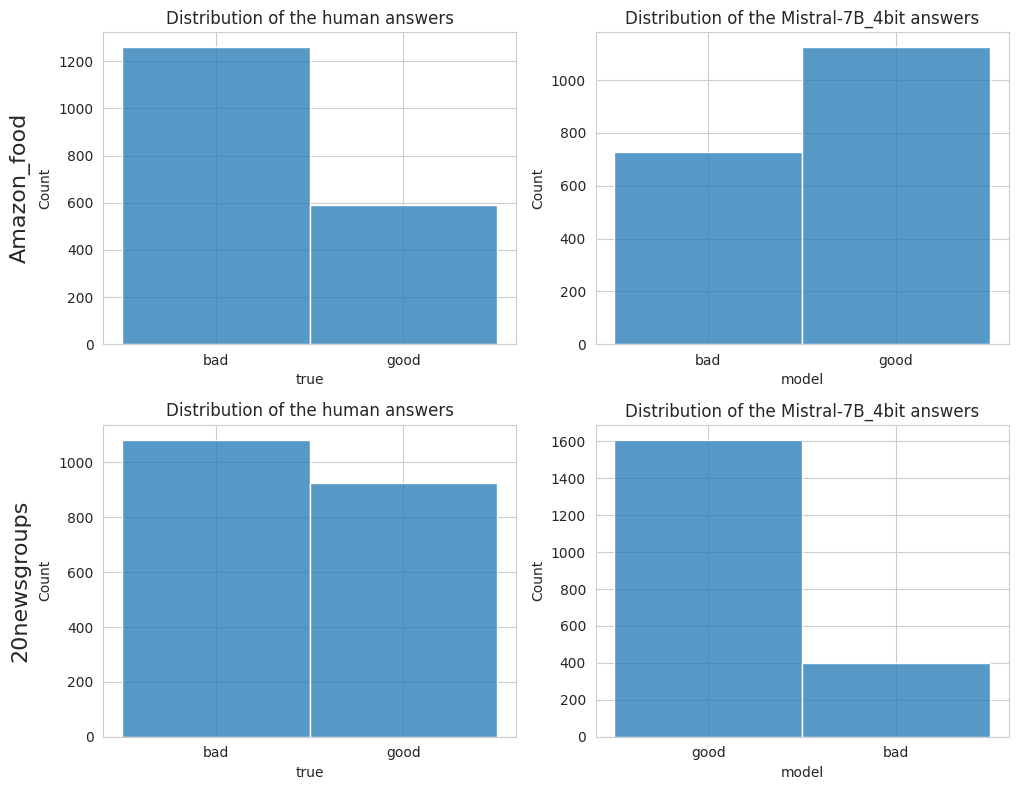

In [46]:
print_answers_distrib(
    data_prompt_mistral_3_amazon,
    data_prompt_mistral_3_newsgroups, 
    model_name="Mistral-7B_4bit"
)

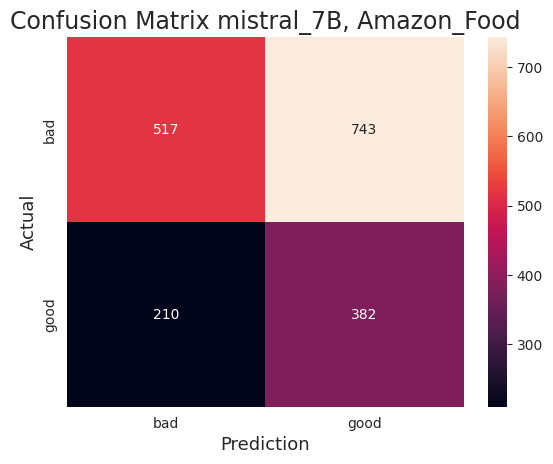

Accuracy: 0.485
F1-score: 0.445
Pearson correlaton: PearsonRResult(statistic=0.05308619564083381, pvalue=0.02233476276397622)


In [47]:
classific_metrics(
    np.array(data_prompt_mistral_3_amazon["true"]), 
    np.array(data_prompt_mistral_3_amazon["model"]), 
    model_name="mistral_7B, Amazon_Food", 
    data_type="str")

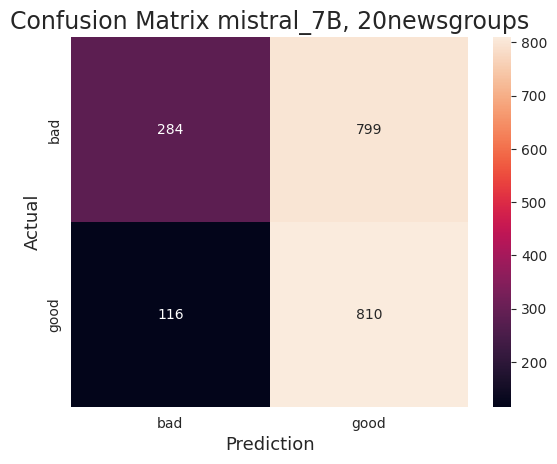

Accuracy: 0.545
F1-score: 0.639
Pearson correlaton: PearsonRResult(statistic=0.17096999370515514, pvalue=1.207007892195254e-14)


In [48]:
classific_metrics(
    np.array(data_prompt_mistral_3_newsgroups["true"]), 
    np.array(data_prompt_mistral_3_newsgroups["model"]), 
    model_name="mistral_7B, 20newsgroups", 
    data_type="str")

/home/alexandra/.pyenv/versions/3.9.7/lib/python3.9/site-packages/phik/data_quality.py:59: UserWarning: The number of unique values of variable text is large: 1852. Are you sure this is not an interval variable? Analysis for pairs of variables including text can be slow.
  warnings.warn(
/home/alexandra/.pyenv/versions/3.9.7/lib/python3.9/site-packages/phik/data_quality.py:59: UserWarning: The number of unique values of variable text is large: 2009. Are you sure this is not an interval variable? Analysis for pairs of variables including text can be slow.
  warnings.warn(


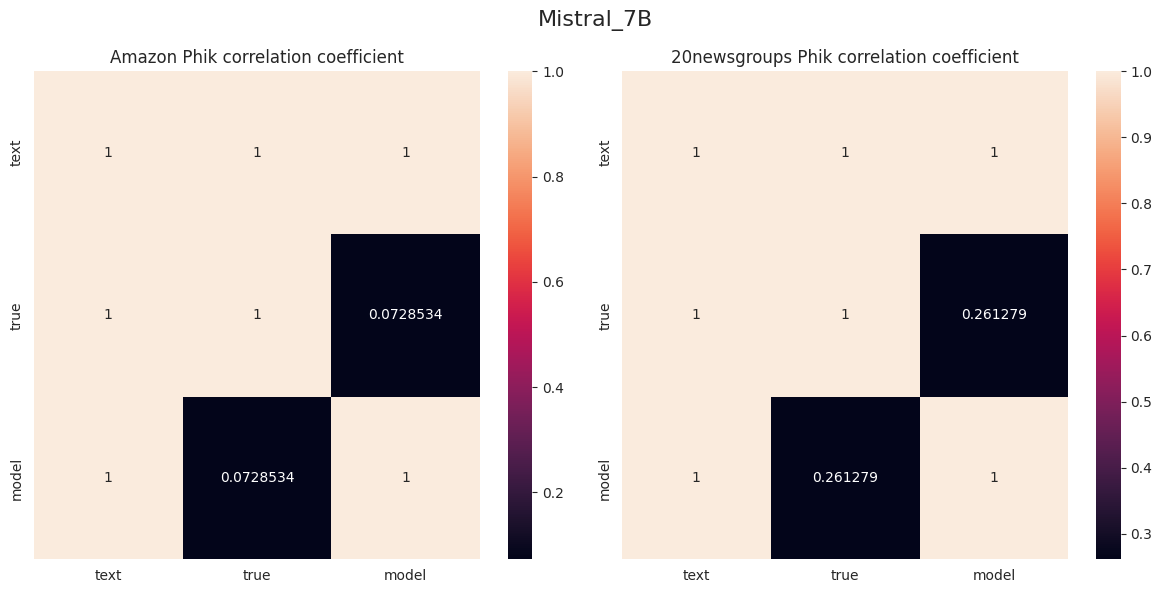

In [49]:
plot_phi_corel(
    data_prompt_mistral_3_amazon, 
    data_prompt_mistral_3_newsgroups, 
    model_name="Mistral_7B"
)

#### Few-Shot Llama

<< SYS >> You are the assistant for text classification << /SYS >>
You will receive a TEXT, and you should answer "YES" or "NO" to the question: "Is it possible to determine a common topic for the TEXT or at least for the most part of the TEXT?". Please, make sure you to only return YES or NO and nothing more.

TEXT: april nasa star canada bike score always goal maynard area player hockey wings center white

ANSWER:

In [36]:
data_prompt_llama_1

,text,true,model
0,pack variety com www http href stash pie grey ...,bad,NO.</s>
1,south island ship secret military rutgers brit...,bad,NO.</s>
2,piece beef jerky everything season break pill ...,bad,NO.</s>
3,mix cream ice pour strawberry stir pancake waf...,good,NO </s>
4,window display screen color server application...,good,NO.</s>
...,...,...,...
3856,engine model rocket band lock foot exhaust pre...,good,NO.</s>
3857,font print character page printer vice cell bi...,good,NO.</s>
3858,delicious small dry hard smaller surprised liv...,bad,NO.</s>
3859,thought end else stick cover boil air china bu...,bad,NO.</s>


In [37]:
data_prompt_llama_1["model"].unique()

array(['NO.</s>', 'NO </s>', 'YES.</s>',
       'NO. There is no common topic that can be determined for the majority of the text. The text appears to be a collection of disconnected words and phrases without a clear theme or topic.</s>',
       'NO. The text does not have a common topic or a clear majority of content related to a specific theme. The text mentions multiple topics such as Israel, Israeli, Arab, Palestinian, country, innocent, human, civilian, murder, peace, trial, and killing, which are not cohesively connected.</s>',
       'NO. There is no common topic that can be determined for the majority of the text. The text mentions various unrelated topics such as country, land, care, Germany, happy, money, waste, German health, company, proposal, Europe, race, and European spend.</s>',
       'NO. There is no common topic that can be determined for the majority of the text. The text mentions a variety of unrelated topics such as internet, water, ground, circuit, connect, servi

In [38]:
tmp_string_ids = []
for i in range(data_prompt_llama_1.shape[0]):
    if "I a" in data_prompt_llama_1["model"].iloc[i]:
        tmp_string_ids.append(i)

In [39]:
for id in tmp_string_ids:
    print(data_prompt_llama_1["model"].iloc[id])

I apologize, but I cannot provide a definitive answer to your question as the text you provided does not contain a common topic or theme that


In [40]:
# Define such answers as "NO"
for id in tmp_string_ids:
    data_prompt_llama_1["model"].iloc[id] = 'NO'

In [41]:
# Extract first three sympols
data_prompt_llama_1["model"] = [x[:3] for x in data_prompt_llama_1["model"]]
data_prompt_llama_1["model"] = [x.replace(".", "").strip() for x in data_prompt_llama_1["model"]]

In [42]:
data_prompt_llama_1["model"] = ["bad" if x=="NO" else "good" for x in data_prompt_llama_1["model"]]

In [43]:
# Divide into two datasets
data_prompt_llama_1_amazon = data_prompt_llama_1[data_prompt_llama_1["text"].isin(amazon_food_texts)]
data_prompt_llama_1_newsgroups = data_prompt_llama_1[data_prompt_llama_1["text"].isin(newsgroups_texts)]

In [44]:
data_prompt_llama_1_amazon.to_csv(DATA_DIR.joinpath("quality_estim_llama_amazon.csv"))
data_prompt_llama_1_newsgroups.to_csv(DATA_DIR.joinpath("quality_estim_llama_newsgroup.csv"))

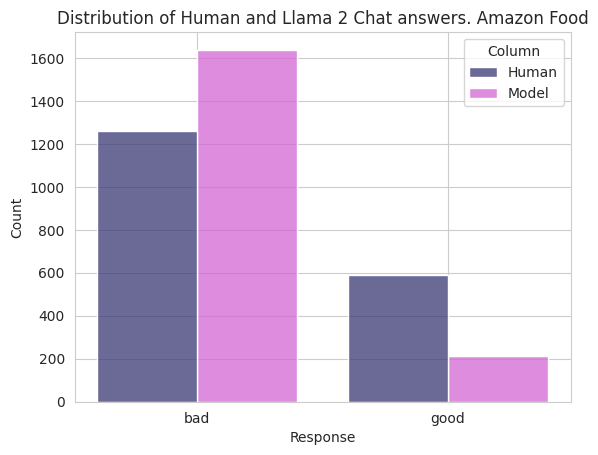

In [45]:
df = data_prompt_llama_1_amazon[["true", "model"]]
df.columns = ["Human", "Model"]
df_long = df.melt(var_name='Column', value_name='Response')

palette_colors = {"Human": "#3A3875", "Model": "#D366D3"}

sns.histplot(data=df_long, x='Response', hue='Column', multiple='dodge', shrink=0.8, palette=palette_colors)

# Установка заголовка
plt.title('Distribution of Human and Llama 2 Chat answers. Amazon Food')

# Отображение графика
plt.show()

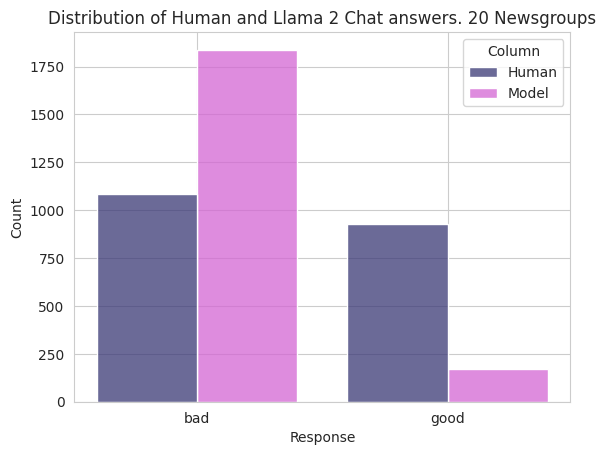

In [46]:
df = data_prompt_llama_1_newsgroups[["true", "model"]]
df.columns = ["Human", "Model"]
df_long = df.melt(var_name='Column', value_name='Response')

palette_colors = {"Human": "#3A3875", "Model": "#D366D3"}

sns.histplot(data=df_long, x='Response', hue='Column', multiple='dodge', shrink=0.8, palette=palette_colors)

# Установка заголовка
plt.title('Distribution of Human and Llama 2 Chat answers. 20 Newsgroups')

# Отображение графика
plt.show()

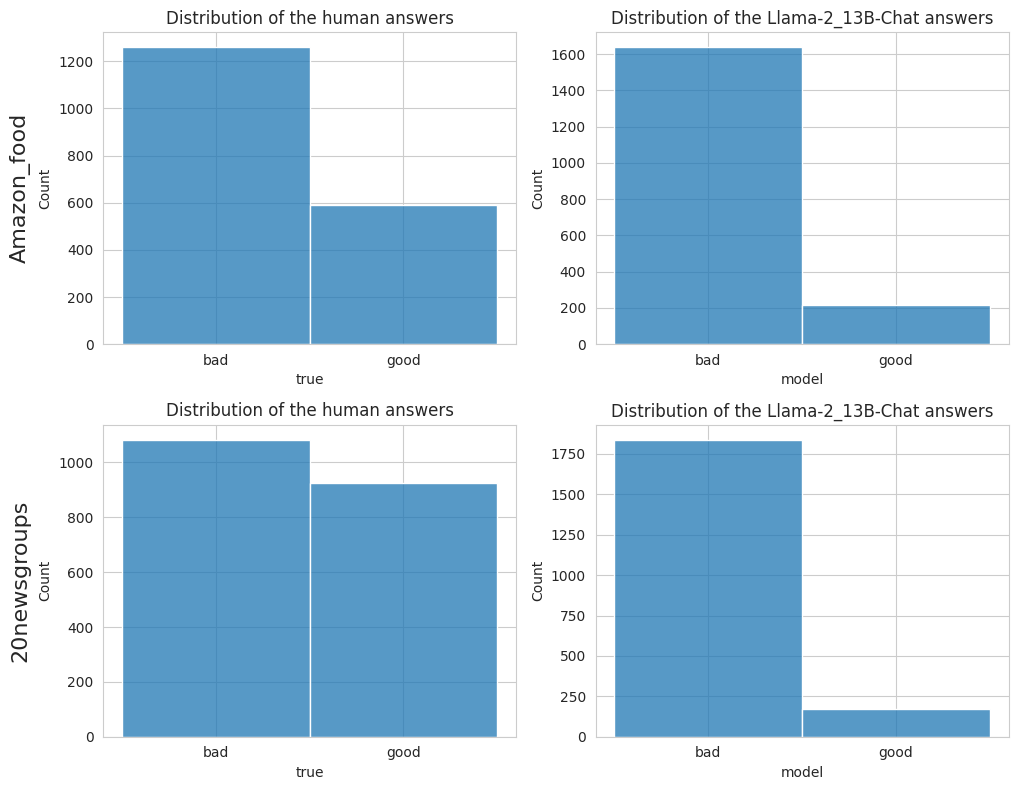

In [59]:
print_answers_distrib(
    data_prompt_llama_1_amazon,
    data_prompt_llama_1_newsgroups, 
    model_name="Llama-2_13B-Chat"
)

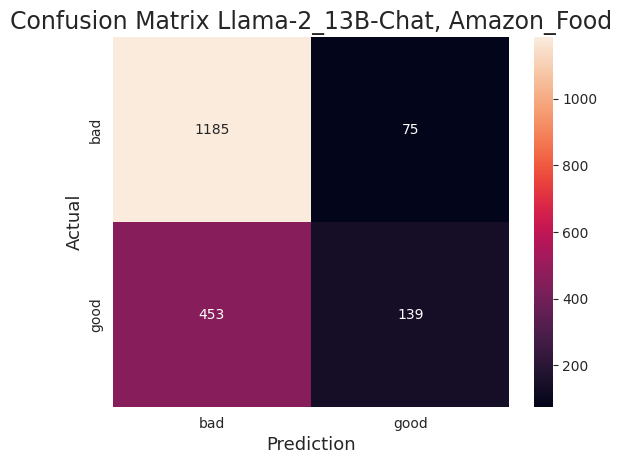

Accuracy: 0.715
F1-score: 0.345
Pearson correlaton: PearsonRResult(statistic=0.25568103715236357, pvalue=4.987059012199252e-29)


In [60]:
classific_metrics(
    np.array(data_prompt_llama_1_amazon["true"]), 
    np.array(data_prompt_llama_1_amazon["model"]), 
    model_name="Llama-2_13B-Chat, Amazon_Food", 
    data_type="str")

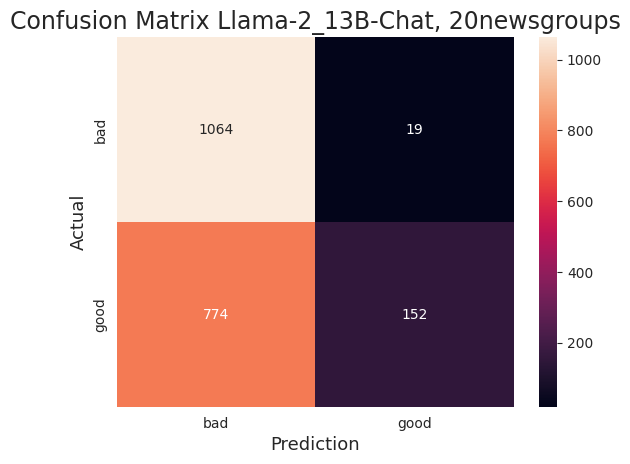

Accuracy: 0.605
F1-score: 0.277
Pearson correlaton: PearsonRResult(statistic=0.26187364668584673, pvalue=7.38290308756287e-33)


In [61]:
classific_metrics(
    np.array(data_prompt_llama_1_newsgroups["true"]), 
    np.array(data_prompt_llama_1_newsgroups["model"]), 
    model_name="Llama-2_13B-Chat, 20newsgroups", 
    data_type="str")

/home/alexandra/.pyenv/versions/3.9.7/lib/python3.9/site-packages/phik/data_quality.py:59: UserWarning: The number of unique values of variable text is large: 1852. Are you sure this is not an interval variable? Analysis for pairs of variables including text can be slow.
  warnings.warn(
/home/alexandra/.pyenv/versions/3.9.7/lib/python3.9/site-packages/phik/data_quality.py:59: UserWarning: The number of unique values of variable text is large: 2009. Are you sure this is not an interval variable? Analysis for pairs of variables including text can be slow.
  warnings.warn(


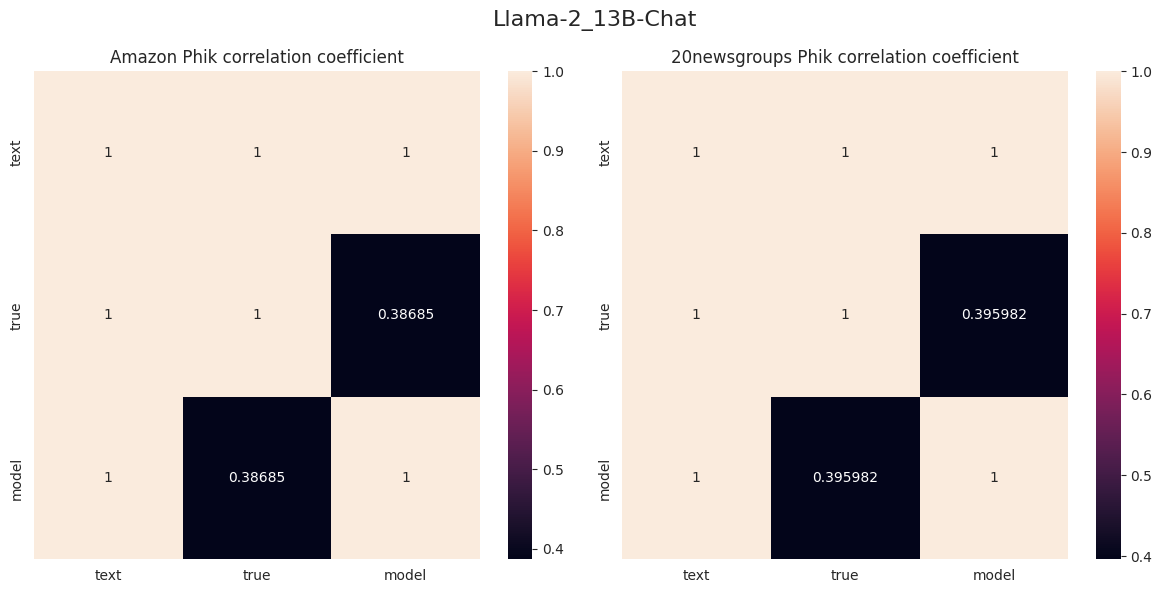

In [62]:
plot_phi_corel(
    data_prompt_llama_1_amazon, 
    data_prompt_llama_1_newsgroups, 
    model_name="Llama-2_13B-Chat"
)

### Naming


In [47]:
def extract_text_in_quotes(input_string):
    pattern = r'"(.*?)"' 
    matches = re.findall(pattern, input_string)
    matches = [string.replace(",", "") for string in matches]
    if len(matches) == 0:
        matches = input_string
    return matches


def extract_substring_after_word(input_string, target_word):
    index = input_string.find(target_word) 
    if index != -1: 
        substring = input_string[index + len(target_word):]  
        return substring.strip()  
    else:
        return input_string
    

def extract_words_in_quotes_after_phrase(input_string):
    pattern = r'the common topic.*? (is|be) "(.*?)"(?: (or|and) "(.*?)")?'  # Паттерн для поиска слов в кавычках после указанной фразы
    matches = re.findall(pattern, input_string)  # Ищем все совпадения с паттерном в строке
    extracted_words = [match[1] for match in matches]  # Извлекаем первое слово из найденных совпадений
    for match in matches:
        if match[3]:  # Если есть второе слово после "or" или "and", добавляем его в список
            extracted_words.append(match[3])
    if extracted_words:
        return extracted_words
    else:
        return input_string
    

def extract_words_between_topic_and_period(input_string):
    pattern = r'topic: (.*?)\.'  # Паттерн для поиска слов между "topic:" и "."
    matches = re.findall(pattern, input_string)  # Ищем все совпадения с паттерном в строке
    
    if matches:
        return matches
    else:
        return input_string
    

def extract_words_after_topic(input_string):
    if isinstance(input_string, list):
        return input_string
    #matches = re.findall(r"topic: (\w+)", input_string)
    matches = re.findall(r"topic: *(.*)", input_string)
    if matches:
        return matches
    else:
        return input_string
    

def extract_words_after_is(input_string):
    if isinstance(input_string, list):
        return input_string
    #matches = re.findall(r"topic: (\w+)", input_string)
    matches = re.findall(r"(?:topic is:|text is:) *(.*)", input_string)
    if matches:
        return matches
    else:
        return input_string

In [48]:
def get_word_embedding(word, tokenizer, model):
    # Токенизация и обработка слова
    inputs = tokenizer(word, return_tensors="pt")
    outputs = model(**inputs)

    # Получение эмбеддинга последнего слоя
    last_hidden_states = outputs.last_hidden_state

    # Возвращаем вектор первого токена (вектор слова)
    return last_hidden_states[0][0]

In [78]:
def print_cos_sim_distrib(amazon_data, newsgroups_data, model_name=""):
    fig, axs = plt.subplots(1, 2, figsize=(12,6))
    
    fig.suptitle(model_name, fontsize=16)

    sns.histplot(data=amazon_data, x="cos_sim_class", ax=axs[0], color="#3A3875")    
    axs[0].set_title("Distribution of the cosine similarity classes Amazon Food")

    sns.histplot(data=newsgroups_data, x="cos_sim_class", ax=axs[1], color="#3A3875")
    axs[1].set_title("Distribution of the cosine similarity classes 20 Newsgroups")

    plt.tight_layout()

    plt.show()

In [50]:
PROMPT_MISTRAL_1 = "data_topic_name_distrib_mistral_7b_4bit_type1_1.csv"
PROMPT_MISTRAL_2 = "data_topic_name_distrib_mistral_7b_4bit_type2_1.csv"
PROMPT_MISTRAL_3 = "data_topic_name_distrib_mistral_7b_4bit_type3_1.csv"
PROMPT_MISTRAL_4 = "data_topic_name_distrib_mistral_7b_4bit_type_new.csv"
PROMPT_LLAMA_1 = "data_topic_name_distrib_llama_13B_4bit_type1.csv"
PROMPT_LLAMA_2 = "data_topic_name_distrib_llama_13B_4bit_new.csv"

PROMPT_MISTRAL_1 = DATA_DIR.joinpath(PROMPT_MISTRAL_1)
PROMPT_MISTRAL_2 = DATA_DIR.joinpath(PROMPT_MISTRAL_2)
PROMPT_MISTRAL_3 = DATA_DIR.joinpath(PROMPT_MISTRAL_3)
PROMPT_MISTRAL_4 = DATA_DIR.joinpath(PROMPT_MISTRAL_4)
PROMPT_LLAMA_1 = DATA_DIR.joinpath(PROMPT_LLAMA_1)
PROMPT_LLAMA_2 = DATA_DIR.joinpath(PROMPT_LLAMA_2)

data_prompt_mistral_1 = pd.read_csv(PROMPT_MISTRAL_1, sep=";", names=["text", "topic"])
data_prompt_mistral_2 = pd.read_csv(PROMPT_MISTRAL_2, sep=";", names=["text", "topic"])
data_prompt_mistral_3 = pd.read_csv(PROMPT_MISTRAL_3, sep=";", names=["text", "topic"])
data_prompt_mistral_4 = pd.read_csv(PROMPT_MISTRAL_4, sep=";", names=["text", "topic"])
data_prompt_llama_1 = pd.read_csv(PROMPT_LLAMA_1, sep=";", names=["text", "topic"])
data_prompt_llama_2 = pd.read_csv(PROMPT_LLAMA_2, sep=";", names=["text", "topic"])

#### Mistral Type I

[INST] You are a helpful, respectful and honest assistant for labeling topics. You will receive a list of words and you should analyze it and label list of words with one or few words. Please, make sure you to only return the topic and nothing more.


Text: ... [/INST]

In [70]:
data_prompt_mistral_1

,text,topic
0,policy peace israeli arab israel proposal tyre...,Israeli-Arab Peace Proposal
1,drinking mild espresso aftertaste brewing latt...,Coffee
2,local piece grocery sell deal carry market gla...,Grocery shopping.
3,value teeth difficult msg pea bone spent rawh ...,Topic: Health and Nutrition
4,bill fire koresh clinton scott child batf comp...,"Bill, Fire, Koresh, Clinton, Scott, Child, Ba..."
...,...,...
2358,package fresh item receive arrive rice soup di...,Gift
2359,period pittsburgh baseball boston player chica...,Baseball
2360,driver card sound cards mode utexas light diam...,Driver Card
2361,image graphics user window code motif format s...,Graphics User Interface (GUI) Development.


In [67]:
data_prompt_mistral_1 = data_prompt_mistral_1.applymap(lambda x: x.lower())
data_prompt_mistral_1["topic"] = [x.replace(".", "") for x in data_prompt_mistral_1["topic"]]
data_prompt_mistral_1["topic"] = [x.replace("/", ", ") for x in data_prompt_mistral_1["topic"]]
data_prompt_mistral_1["topic"] = [x.replace("-", " ") for x in data_prompt_mistral_1["topic"]]

for i, topic in enumerate(data_prompt_mistral_1["topic"]):
    # Extract topics in quotes
    topic = extract_text_in_quotes(topic)
    if isinstance(topic, list):
        topic = ", ".join(topic)

    topic = extract_substring_after_word(topic, "topic:")

    data_prompt_mistral_1["topic"].iloc[i] = topic

data_prompt_mistral_1["topic"] = [x.strip() for x in data_prompt_mistral_1["topic"]]

1. Для некоторых данных модель выдает просто список слов в качестве топиков. Предлагается убрать данные наборы

In [28]:
data_prompt_mistral_1["text_col_tmp"] = [data_prompt_mistral_1["topic"].iloc[i].replace(",", "").strip() for i in range(data_prompt_mistral_1.shape[0])]

In [29]:
data_prompt_mistral_1["tmp"] = data_prompt_mistral_1["text"] == data_prompt_mistral_1["text_col_tmp"]

In [30]:
data_prompt_mistral_1

,text,topic,text_col_tmp,tmp
0,policy peace israeli arab israel proposal tyre...,israeli arab peace proposal,israeli arab peace proposal,False
1,drinking mild espresso aftertaste brewing latt...,coffee,coffee,False
2,local piece grocery sell deal carry market gla...,grocery shopping,grocery shopping,False
3,value teeth difficult msg pea bone spent rawh ...,health and nutrition,health and nutrition,False
4,bill fire koresh clinton scott child batf comp...,"bill, fire, koresh, clinton, scott, child, bat...",bill fire koresh clinton scott child batf comp...,True
...,...,...,...,...
2358,package fresh item receive arrive rice soup di...,gift,gift,False
2359,period pittsburgh baseball boston player chica...,baseball,baseball,False
2360,driver card sound cards mode utexas light diam...,driver card,driver card,False
2361,image graphics user window code motif format s...,graphics user interface (gui) development,graphics user interface (gui) development,False


In [31]:
print("The number of identical topics:", sum(data_prompt_mistral_1["tmp"]))
ids = data_prompt_mistral_1.index[data_prompt_mistral_1["tmp"]].tolist()
for text in data_prompt_mistral_1["text"].loc[ids]:
    print(text)


The number of identical topics: 132
bill fire koresh clinton scott child batf compound stratus waco cult tear agent burn today
berkeley court charge anti francisco hate dangerous jacket legal property judge california leather museum lawyer
nasa research science center launch earth satellite orbit internet national mission anonymous project april address
nasa science earth orbit mission launch library moon satellite news reference image shuttle access general
michael child koresh judge phil rutgers witness tear branch trial rock cult ians ence kaldis
chip star potato salty corn veggie reason vinegar kettle rating think still whole addictive garden
driver card memory machine running sound cards error simms instal anybody fine works check wonder
unix directory resource keyboard comp user application email graphics converter package server format library hardware
internet ground circuit water connect service tower contact email heat outlet plant site network nist
anonymous news bill public

In [32]:
data_prompt_mistral_1 = data_prompt_mistral_1[data_prompt_mistral_1["tmp"]==False]
data_prompt_mistral_1 = data_prompt_mistral_1.drop(["text_col_tmp", "tmp"], axis=1)

In [ ]:
data_prompt_mistral_1

,text,topic
0,policy peace israeli arab israel proposal tyre...,israeli arab peace proposal
1,drinking mild espresso aftertaste brewing latt...,coffee
2,local piece grocery sell deal carry market gla...,grocery shopping
3,value teeth difficult msg pea bone spent rawh ...,topic: health and nutrition
5,way drinking mild aftertaste espresso weird si...,coffee
...,...,...
2358,package fresh item receive arrive rice soup di...,gift
2359,period pittsburgh baseball boston player chica...,baseball
2360,driver card sound cards mode utexas light diam...,driver card
2361,image graphics user window code motif format s...,graphics user interface (gui) development


Для одного набора текста модель выдала цитату (удалить из набора)

In [40]:
for topic in data_prompt_mistral_1["topic"]:
    print(topic)

israeli arab peace proposal
coffee
grocery shopping
health and nutrition
coffee
space exploration
technology, offers, sales, email, bike, phone, cost, internet, distribution, money
electronics
scsi controller
bulk buying
snacks
ingredient
coconut health benefits
morality, school, keith, caltech, animal, morality, human lives, definition, natural behavior, goal, humans, learning, solntze
performance upgrade
israel, palestine conflict
electrical wiring
uiuc, frank, love, andrew, cwru, james, thought, ever, chris, disclaimer, george michael
graphics, user, contact, info, package, format, unix, site, tool, machine, directory, code, type, library
healthy drinks
family, home, city, death, helmet, mother, father, child, apartment, left, kill
chocolate chip sauce
bottled water
food ingredients
weapon safety
salad dressing
feed
space exploration
drug court
image processing
sports
bottled drinks
house
graphics user interface (gui)
spicy asian cuisine
medicine
image graphics package format code u

In [38]:
print(data_prompt_mistral_1["text"].iloc[55])
print(data_prompt_mistral_1["topic"].iloc[55])

quality chicken meat vegetable hazelnut purchasing tuna turkey hooked pricey steak thick we're grill base
food shopping


Данный промпт не подходит, так как сложный процесс постобработки, часто на вопрос модель отвечает чисто списком исходных слов, аналогично второй вид промпта

#### Zero-Shot Mistral

You will receive a list of words and you should analyze it and name the common topic with one or few words.

In [68]:
data_prompt_mistral_3

,text,topic
0,scsi controller interface disk transfer bios f...,"The common topic in this list is ""Storage Dev..."
1,natural list contains raw berry book usa herb ...,"The common topic in the given text is ""natura..."
2,package shipping plastic offer delivery four g...,The common topic in the given text appears to...
3,drug court legal police illegal laws charge pr...,"The common topic in the given text is ""Legal ..."
4,israeli arab tape population border village po...,"The common topic in this list is ""Israel-Pale..."
...,...,...
2358,internet ground circuit water connect service ...,"The common topic in the given text is ""network."""
2359,ground wire connect panel outlet circuit wirin...,"The common topic in the given text is ""electr..."
2360,argument moral keith ence conclusion imply def...,The common topic in the given list of words i...
2361,organic natural real expensive syrup high arti...,"The common topic in this list of words is ""fo..."


In [74]:
# Extract topic in quotes
# The common topic ... is / to be " " / " " or " " / " " and " "

example_1 = 'the common topic in this list of words is "food" and "meat."'
example_2 = 'the common topic in the given text is "bulk buying" or "bulk purchasing."'
example_3 = 'the common topic in the given list of words is "display".'
example_4 = 'the common topic in the given text appears to be "shipping" and "delivery."'
example_5 = 'the common topic in this list of words is "coffee" and "tea" as they are both mentioned in the words "blend," "decaf," "caffeine," and "herbal."'
example_6 = 'space exploration.'
example_7 = 'the common topic is "Internet" and "Privacy."'
example_8 = 'the common topic in the given text could be "playthings" or "toys" as several words in the list are related to toys, such as "puppy," "toy," "play," "senseo," and "creamer."'

example_1 = extract_words_in_quotes_after_phrase(example_1)
example_2 = extract_words_in_quotes_after_phrase(example_2)
example_3 = extract_words_in_quotes_after_phrase(example_3)
example_4 = extract_words_in_quotes_after_phrase(example_4)
example_5 = extract_words_in_quotes_after_phrase(example_5)
example_6 = extract_words_in_quotes_after_phrase(example_6)
example_7 = extract_words_in_quotes_after_phrase(example_7)
example_8 = extract_words_in_quotes_after_phrase(example_8)

print(example_1)
print(example_2)
print(example_3)
print(example_4)
print(example_5)
print(example_6)
print(example_7)
print(example_8)

['food', 'meat.']
['bulk buying', 'bulk purchasing.']
['display']
['shipping', 'delivery.']
['coffee', 'tea']
space exploration.
['Internet', 'Privacy.']
['playthings', 'toys']


In [70]:

data_prompt_mistral_3["topic"] = [extract_words_in_quotes_after_phrase(topic) for topic in data_prompt_mistral_3["topic"]]

In [61]:
for topic in data_prompt_mistral_3["topic"]:
    print(topic)

['Storage Devices', 'Storage Interface']
['natural ingredients']
['shipping', 'delivery.']
['Legal Issues', 'Criminal Justice.']
['Israel-Palestine Conflict']
['spicy pepper sauce.']
['hardware']
['hockey.']
['study', 'effects']
['graphics']
['NASA', 'research']
['rice meal.']
['legal', 'lawyer']
['electrical wiring.']
['launch', 'project.']
['email', 'usenet news.']
['Sales', 'Offer.']
['beverages', 'drinks']
['graphics', 'image processing']
['Israel', 'encryption.']
['test', 'output']
['health.']
['food', 'drink.']
 Space exploration.
['Religion', 'Spirituality']
['Sale', 'Machine']
['diet', 'healthy eating.']
['genocide', 'massacre,']
['food', 'meal.']
['coffee', 'tea']
 Nazi Party, Hitler, Islam, Resurrection, History, Faith, Ence, Dead, Found, Ticket.
['Religion', 'Spirituality']
 Space exploration.
['time,']
['sale', 'selling']
['computer hardware', 'computer peripherals']
['food.']
['baby', 'child development.']
['soup.']
['food', 'breakfast foods']
 Topic: Morality and Ethics
[

#### Zero-Shot Llama-2  
< s > [INST] << SYS >> You are an assistant for topic modeling. << SYS >>
You will receive the TEXT and you should identify one or few TOPICS of the TEXT. Provide ONLY TOPICS and nothing more.
TEXT: bar sweet crunchy yummy cinnamon granola yogurt crunch cereal raisin flake snack almond combination blueberry
TOPIC: [/INST]

In [114]:
data_prompt_llama_1

,text,topic
0,population bullet arab israeli border village ...,"Sure, I'd be happy to help!The topic of the te..."
1,quote hell context death accept evil agree fee...,Sure! Here's the topic of the text you provide...
2,enjoy strong morning brew blend bitter smooth ...,Sure! Here's the topic of the text you provide...
3,worth packet waste splenda world horrible when...,Sure! Here's the topic of the text you provide...
4,pres administration official congress secretar...,Sure! Here is the topic of the text you provid...
...,...,...
2376,sauce serve per regular save hot red bit spicy...,Sure! Here's the topic of the text you provide...
2377,israel pres israeli encryption security arab p...,Sure! Here is the topic of the text you provid...
2378,arab israeli israel policy thousand none borde...,"Sure, I'd be happy to help!The topic of the te..."
2379,land country care health drug disease money ha...,"Sure, I'd be happy to help!Topic: Healthcare</s>"


In [137]:
for topic in data_prompt_llama_1["topic"]:
    print(topic)

Sure, I'd be happy to help!The topic of the text you provided is:TOPIC: Religion</s>
Sure! Here's the topic of the text you provided:TOPIC: Death</s>
Sure! Here's the topic of the text you provided:TOPIC: Coffee</s>
Sure! Here's the topic of the text you provided:TOPIC: Sweeteners</s>
Sure! Here is the topic of the text you provided:TOPIC: POLITICS</s>
Sure! Here's the topic of the text you provided:TOPIC: Religion</s>
Sure, I'd be happy to help! Here's the topic of the text you provided:TOPIC: Education</s>
Sure! Here is the topic of the text you provided:TOPIC: Conflict and Violence in the Middle East</s>
Sure! Here's the topic of the text you provided:TOPIC: FOOD</s>
Sure! Here's the topic of the text you provided:TOPIC: Party Planning</s>
Sure! Here's the topic of the text you provided:TOPIC: Electronics</s>
Sure! Here is the topic of the text you provided:TOPIC: Space Exploration</s>
Sure, I'd be happy to help! Here are the topics I identified in the text you provided:TOPIC: Snack

In [138]:
data_prompt_llama_1["topic"] = [x.lower() for x in data_prompt_llama_1["topic"]]
data_prompt_llama_1["topic"] = [x.replace("</s>", "") for x in data_prompt_llama_1["topic"]]

In [132]:
data_prompt_llama_1["topic"] = [extract_words_between_topic_and_period(x) for x in data_prompt_llama_1["topic"]]
data_prompt_llama_1["topic"] = [extract_words_after_topic(x) for x in data_prompt_llama_1["topic"]]
data_prompt_llama_1["topic"] = [extract_words_after_is(x) for x in data_prompt_llama_1["topic"]]

#### Zero-shot Mistral New
You are the topic modeling assistant. You should extract the main theme that combines all the words from the list. Formulate it with a single word:

In [51]:
data_prompt_mistral_4

,text,topic
0,earth orbit nasa mission moon satellite lunar ...,The main theme that combines all the words fr...
1,dog treat training liver greenies ball pup dog...,The main theme that combines all the words fr...
2,morning breakfast light packet indiv mild conv...,The main theme that combines all the words fr...
3,snack chip healthy tasty family cheese they're...,The main theme that combines all the words fr...
4,hell alaska eternal liar motto main acad crazy...,The main theme that combines all the words fr...
...,...,...
2358,moral objective science morality keith animal ...,The main theme that combines all the words fr...
2359,company insurance happy money private health a...,The main theme that combines all the words fr...
2360,science moral objective study morality disease...,The main theme that combines all the words fr...
2361,price islamic turbo tube charge cheer rice mon...,The main theme that combines all the words fr...


In [52]:
for topic in data_prompt_mistral_4["topic"]:
    print(topic)

 The main theme that combines all the words from the list is "space exploration."</s>
 The main theme that combines all the words from the list is "training."</s>
 The main theme that combines all the words from the list is "convenience".</s>
 The main theme that combines all the words from the list is "snacking."</s>
 The main theme that combines all the words from the list is "crazy."</s>
 The main theme that combines all the words from the list is "sweetener."</s>
 "Addictive"</s>
 The main theme that combines all the words from the list is "computer."</s>
 The main theme that combines all the words from the list is "health".</s>
 The main theme that combines all the words from the list is "healthy."</s>
 "Playoffs"</s>
 The main theme that combines all the words from the list is "Usenet".</s>
 The main theme that combines all the words from the list is "Religion".</s>
 The main theme that combines all the words from the list is "dessert."</s>
 The main theme that combines all the w

In [53]:
data_prompt_mistral_4["topic"] = [x.lower() for x in data_prompt_mistral_4["topic"]]
data_prompt_mistral_4["topic"] = [x.replace("</s>", "") for x in data_prompt_mistral_4["topic"]]
data_prompt_mistral_4["topic"] = [x.replace(".", "") for x in data_prompt_mistral_4["topic"]]

In [54]:
data_prompt_mistral_4["topic"] = [extract_text_in_quotes(x) for x in data_prompt_mistral_4["topic"]]

In [55]:
for i, topic in enumerate(data_prompt_mistral_4["topic"]):
    if isinstance(topic, str):
        data_prompt_mistral_4["topic"].iloc[i] = [topic]
        topic = topic.strip()
    else:
        for j, elem in enumerate(data_prompt_mistral_4["topic"].iloc[i]):
            data_prompt_mistral_4["topic"].iloc[i][j] = data_prompt_mistral_4["topic"].iloc[i][j].strip()

In [56]:
data_prompt_mistral_4

,text,topic
0,earth orbit nasa mission moon satellite lunar ...,[space exploration]
1,dog treat training liver greenies ball pup dog...,[training]
2,morning breakfast light packet indiv mild conv...,[convenience]
3,snack chip healthy tasty family cheese they're...,[snacking]
4,hell alaska eternal liar motto main acad crazy...,[crazy]
...,...,...
2358,moral objective science morality keith animal ...,[ethics]
2359,company insurance happy money private health a...,[healthcare]
2360,science moral objective study morality disease...,[ethics]
2361,price islamic turbo tube charge cheer rice mon...,[islam]


#### Get Real Data

In [57]:
# Extract human naming
BASE_DIR = Path('result_analysis.ipynb').resolve().parent.parent
original_data_dir = BASE_DIR.joinpath('data/datasets')
original_naming_file = "data_topic_name_distrib.csv"
original_naming_file = original_data_dir.joinpath(original_naming_file)
original_naming = pd.read_csv(original_naming_file, sep=",")

In [58]:
original_naming

,INPUT:wordset,OUTPUT:quality,OUTPUT:topic_name,topic_name_num
0,able amaze fill stop glad daily fantastic move...,good,feelings,1
1,absolute mission church nasa mars earth truth ...,good,astrology,1
2,absolute mission church nasa mars earth truth ...,good,nasa,1
3,absolute mission church nasa mars earth truth ...,good,space,1
4,absolute mission church nasa mars earth truth ...,good,space mission,1
...,...,...,...,...
5761,year two size old every last month start since...,good,year,1
5762,year two size old every last month start week ...,good,baby,1
5763,year two size old every last month start week ...,good,child,1
5764,year two size old every last month start week ...,good,time,1


In [59]:
# Extract topis for similar topics
topic_name_true = []
text_lst = []
unique_wordset = list(set(original_naming["INPUT:wordset"]))
for wordset in unique_wordset:
    text_lst.append(wordset)
    topics = list(set(original_naming["OUTPUT:topic_name"][original_naming["INPUT:wordset"]==wordset]))

    topic_name_true.append(topics)

original_topics_df = pd.DataFrame(data={"text": unique_wordset, "topics": topic_name_true})
original_topics_df

,text,topics
0,argument colorado music letter conclusion fall...,[music]
1,salt bean dish cooking sea kitchen gourmet por...,"[cooking, cooking ]"
2,send address email news request message intern...,"[communication, mail, mailing, message]"
3,greek turkish turkey cross armenia henrik turk...,"[different countries and nations, countries ]"
4,woman city home left building apartment mother...,"[home and family , residence]"
...,...,...
2358,guess wave roger wrong tape story ryan previou...,[guess ]
2359,quote hell death evil context accept feel agre...,[god quote]
2360,price board monitor port shipping slot cards s...,[computers]
2361,less calorie protein amount low fat fiber weig...,"[healthy lifestyle, diet guide]"


#### Simple Example

In [60]:
sen = [
    "cat",
    "kitty",
    "dog",
    "road",
    "fish",
    "tiger",
    "three cat"
]

In [61]:
model = SentenceTransformer('bert-base-nli-mean-tokens')
#Encoding:
sen_embeddings = model.encode(sen)
sen_embeddings.shape

(7, 768)

In [62]:
#let's calculate cosine similarity for sentence 0:
cosine_similarity(
    [sen_embeddings[0]],
    sen_embeddings[1:]
)

array([[0.71756035, 0.23537238, 0.3100229 , 0.24783944, 0.5335132 ,
        0.94091886]], dtype=float32)

#### Calculate metric Mistral (пока возьмем, что модель формулирует одно слово как указано в промпте)

In [63]:
# Combine model topics with original ones
original_topics_lst = []

for text in data_prompt_mistral_4["text"]:
    original_topic = original_topics_df.loc[original_topics_df["text"]==text, "topics"].values[0]
    original_topics_lst.append(original_topic)

data_prompt_mistral_4["true_topic"] = original_topics_lst

In [64]:
data_prompt_mistral_4

,text,topic,true_topic
0,earth orbit nasa mission moon satellite lunar ...,[space exploration],"[space, space program, nasa researcg, lunar]"
1,dog treat training liver greenies ball pup dog...,[training],"[dog training, pets , dog]"
2,morning breakfast light packet indiv mild conv...,[convenience],[morning]
3,snack chip healthy tasty family cheese they're...,[snacking],"[snacks, snacks ]"
4,hell alaska eternal liar motto main acad crazy...,[crazy],[fılm]
...,...,...,...
2358,moral objective science morality keith animal ...,[ethics],"[morality, study of animals , values]"
2359,company insurance happy money private health a...,[healthcare],"[insurance, health insurance]"
2360,science moral objective study morality disease...,[ethics],"[treatment , science article]"
2361,price islamic turbo tube charge cheer rice mon...,[islam],[islam ]


In [65]:
for topic in data_prompt_mistral_4["topic"]:
    print(topic)

['space exploration']
['training']
['convenience']
['snacking']
['crazy']
['sweetener']
['addictive']
['computer']
['health']
['healthy']
['playoffs']
['usenet']
['religion']
['dessert']
['dessert']
['nation']
['purchase']
['coffee']
['religion']
['summer']
['natural']
['security']
['coffee']
['justice']
['sports']
['germany']
['care']
['medical']
['sports']
[' flavor']
['island']
['crime']
['food']
['healthy']
['dessert']
['baby']
['health']
['hardware']
['crime']
['spirituality']
['nutrition']
['gun control']
['natural']
['crime']
['convenience']
['electrical wiring']
['cooking']
['nutrition']
['display']
['healthy']
['hockey']
['baseball']
['healthy']
['bread']
['dessert']
['thai rice bowl']
[' space exploration']
['dessert']
['violence']
['drink']
['commerce']
['coffee']
['snack']
['nature']
['island']
['health']
['religion']
['snack']
['addiction']
['cooling']
['saturday']
['diet']
['summer']
['security']
['security']
['space exploration']
['israel']
[' electrical']
['grooming']
[

In [66]:
example = data_prompt_mistral_4.iloc[0]

topic_embeddings = model.encode(example["topic"])
true_topic_embeddings = model.encode(example["true_topic"])
true_topic_embeddings.shape

(4, 768)

In [67]:
cosine_similarity(
    topic_embeddings,
    true_topic_embeddings
)

array([[0.8688483 , 0.95342886, 0.7536278 , 0.72468615]], dtype=float32)

#### Data Preprocessing
1) Remove punktuation
2) Remove extraspaces
3) Lemmatize

In [68]:
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

# Необходимо скачать словарные ресурсы NLTK
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')

# Функция для определения части речи, нужной для лемматизатора
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

# Инициализация лемматизатора
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/alexandra/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/alexandra/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /home/alexandra/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [69]:
data_preprocessor = data_preprocessing.TextPreprocessor(lang='eng')

for i in range(len(data_prompt_mistral_4["topic"])):
    topic = data_prompt_mistral_4.iloc[i]["topic"][0]
    true_topic = data_prompt_mistral_4.iloc[i]["true_topic"]

    # topic
    topic = data_preprocessor.remove_punct(topic)
    topic = data_preprocessor.remove_ext_spaces(topic)
    topic = data_preprocessor.tokenize(topic)
    topic = " ".join([lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in topic])

    # true topic
    for j, true_topic_tmp in enumerate(true_topic):
        true_topic_tmp = data_preprocessor.remove_punct(true_topic_tmp)
        true_topic_tmp = data_preprocessor.remove_ext_spaces(true_topic_tmp)
        true_topic_tmp = data_preprocessor.tokenize(true_topic_tmp)
        true_topic_tmp = " ".join([lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in true_topic_tmp])
        true_topic[j] = true_topic_tmp

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/alexandra/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/alexandra/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /home/alexandra/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [70]:
# Calculate average cosine similarity 
cos_sim_avg = []
for i in tqdm(range(data_prompt_mistral_4.shape[0])):
    sample = data_prompt_mistral_4.iloc[i]

    topic_embeddings = model.encode(sample["topic"])
    true_topic_embeddings = model.encode(sample["true_topic"])

    cos_sim = cosine_similarity(topic_embeddings, true_topic_embeddings)[0]
    cos_sim_avg.append(sum(cos_sim) / len(cos_sim))

data_prompt_mistral_4["cos_sim"] = cos_sim_avg

  0%|          | 0/2363 [00:00<?, ?it/s]

100%|██████████| 2363/2363 [03:58<00:00,  9.90it/s]


In [71]:
data_prompt_mistral_4

,text,topic,true_topic,cos_sim
0,earth orbit nasa mission moon satellite lunar ...,[space exploration],"[space, space program, nasa researcg, lunar]",0.825148
1,dog treat training liver greenies ball pup dog...,[training],"[dog training, pet, dog]",0.617334
2,morning breakfast light packet indiv mild conv...,[convenience],[morning],0.555207
3,snack chip healthy tasty family cheese they're...,[snacking],"[snack, snack]",0.949242
4,hell alaska eternal liar motto main acad crazy...,[crazy],[fılm],0.469943
...,...,...,...,...
2358,moral objective science morality keith animal ...,[ethics],"[morality, study of animal, value]",0.696786
2359,company insurance happy money private health a...,[healthcare],"[insurance, health insurance]",0.766396
2360,science moral objective study morality disease...,[ethics],"[treatment, science article]",0.557746
2361,price islamic turbo tube charge cheer rice mon...,[islam],[islam],1.000000


Semantic cosine similarity ranges:
1. Very High Similarity: VH

**Cosine similarity: 0.8 to 1.0**

This range suggests that the vectors are almost identical in orientation, indicating a very high degree of similarity.

2. High Similarity: H

**Cosine similarity: 0.6 to 0.8**

Vectors are closely aligned, suggesting a high level of similarity.

3. Moderate Similarity: M

**Cosine similarity: 0.3 to 0.6**

This range indicates a moderate level of similarity, with vectors somewhat aligned.

4. Low Similarity: L

**Cosine similarity: 0 to 0.3**

Vectors are not very well aligned, suggesting a low degree of similarity.

5. Very Low or Negative Similarity: VL

**Cosine similarity: -1.0 to 0**

A negative value indicates that the vectors are pointing in more opposite directions, suggesting dissimilarity. Values close to 0 but negative might indicate a very low degree of similarity.

In [72]:
cos_sim_range = []

for cos_sim in data_prompt_mistral_4["cos_sim"]:
    if cos_sim >= 0.8:
        cos_sim_range.append("VH")
    elif cos_sim >= 0.6 and cos_sim < 0.8:
        cos_sim_range.append("H")
    elif cos_sim >= 0.3 and cos_sim < 0.6:
        cos_sim_range.append("M")
    elif cos_sim >= 0.0 and cos_sim < 0.3:
        cos_sim_range.append("L")
    else:
        cos_sim_range.append("VL")

data_prompt_mistral_4["cos_sim_class"] = cos_sim_range

In [73]:
data_prompt_mistral_4

,text,topic,true_topic,cos_sim,cos_sim_class
0,earth orbit nasa mission moon satellite lunar ...,[space exploration],"[space, space program, nasa researcg, lunar]",0.825148,VH
1,dog treat training liver greenies ball pup dog...,[training],"[dog training, pet, dog]",0.617334,H
2,morning breakfast light packet indiv mild conv...,[convenience],[morning],0.555207,M
3,snack chip healthy tasty family cheese they're...,[snacking],"[snack, snack]",0.949242,VH
4,hell alaska eternal liar motto main acad crazy...,[crazy],[fılm],0.469943,M
...,...,...,...,...,...
2358,moral objective science morality keith animal ...,[ethics],"[morality, study of animal, value]",0.696786,H
2359,company insurance happy money private health a...,[healthcare],"[insurance, health insurance]",0.766396,H
2360,science moral objective study morality disease...,[ethics],"[treatment, science article]",0.557746,M
2361,price islamic turbo tube charge cheer rice mon...,[islam],[islam],1.000000,VH


In [74]:
# Divide entire data into two datasets
data_prompt_mistral_4_amazon = data_prompt_mistral_4[data_prompt_mistral_4["text"].isin(amazon_food_texts)]
data_prompt_mistral_4_newsgroups = data_prompt_mistral_4[data_prompt_mistral_4["text"].isin(newsgroups_texts)]
print(f"Amazon:", data_prompt_mistral_4_amazon.shape)
print(f"20newsgroups:", data_prompt_mistral_4_newsgroups.shape)

Amazon: (932, 5)
20newsgroups: (1431, 5)


/tmp/ipykernel_19413/671716890.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_prompt_mistral_4_amazon["cos_sim_class"] = pd.Categorical(
/tmp/ipykernel_19413/671716890.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_prompt_mistral_4_newsgroups["cos_sim_class"] = pd.Categorical(


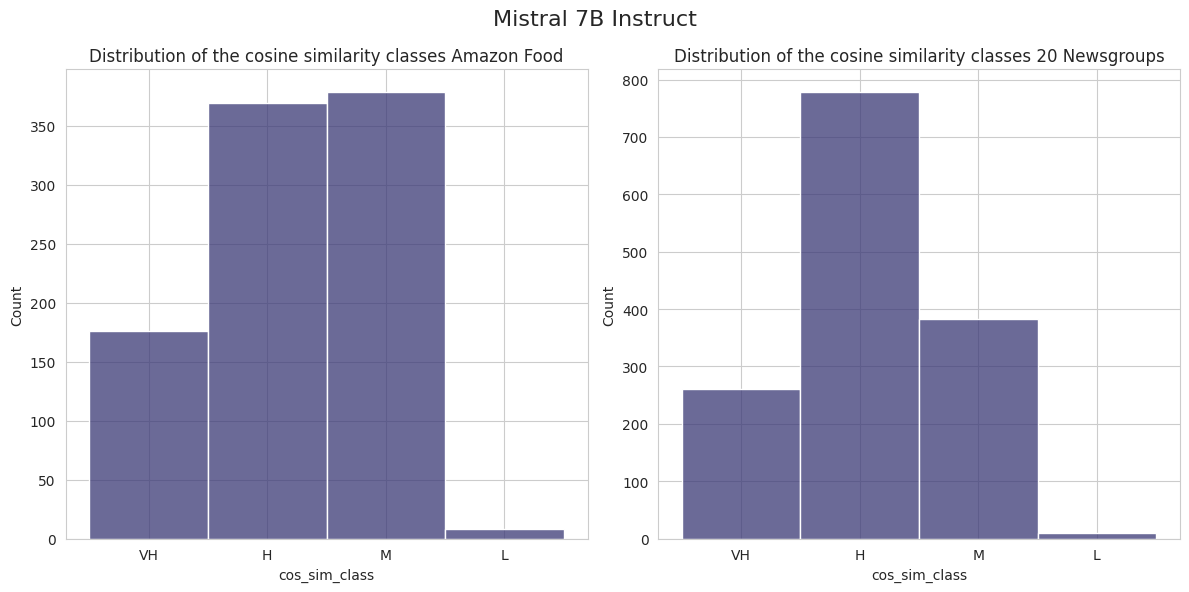

In [79]:
data_prompt_mistral_4_amazon["cos_sim_class"] = pd.Categorical(
    data_prompt_mistral_4_amazon['cos_sim_class'], 
    categories=['VH', 'H', 'M', 'L', 'VL'], ordered=True
)
data_prompt_mistral_4_newsgroups["cos_sim_class"] = pd.Categorical(
    data_prompt_mistral_4_newsgroups['cos_sim_class'], 
    categories=['VH', 'H', 'M', 'L', 'VL'], ordered=True
)



(data_prompt_mistral_4_amazon, data_prompt_mistral_4_newsgroups, model_name="Mistral 7B Instruct")

In [104]:
data_prompt_mistral_4_amazon.to_csv(DATA_DIR.joinpath("topic_name_mistral_7B_amazon.csv"))
data_prompt_mistral_4_newsgroups.to_csv(DATA_DIR.joinpath("topic_name_mistral_7B_20newsgroup.csv"))

In [105]:
grouped_cos_sim_amazon = data_prompt_mistral_4_amazon['cos_sim_class'].value_counts().sort_index()
grouped_cos_sim_newsgroups = data_prompt_mistral_4_newsgroups['cos_sim_class'].value_counts().sort_index()

In [106]:
print("Amazon_food:\n", grouped_cos_sim_amazon)
print("20newsgroups:\n", grouped_cos_sim_newsgroups)

Amazon_food:
 VH    176
H     369
M     379
L       8
VL      0
Name: cos_sim_class, dtype: int64
20newsgroups:
 VH    260
H     779
M     383
L       9
VL      0
Name: cos_sim_class, dtype: int64


#### Zero-shot Llama New
< s >[INST] << SYS >> You are the topic modeling assistant. <<\SYS>> You should understand the main theme that combines all the words from the list. Formulate it with a single word, print only this word in quotes and no additional text: quality chicken meat ingredient vegetable purchasing salmon hazelnut pricey base turkey tuna filler steak actually [/INST]

In [80]:
data_prompt_llama_2

,text,topic
0,encryption chip clipper security phone privacy...,"Sure! Based on the list of words provided, the..."
1,function code text islam muslim null subject e...,"Sure! Based on the list of words provided, the..."
2,package fresh item receive rice arrive gift di...,"Sure! Based on the list of words you provided,..."
3,chew pod pound toy bone caramel larger play pe...,"Sure! Based on the list of words you provided,..."
4,player hockey season league goal leaf playoff ...,"Sure! Based on the list of words you provided,..."
...,...,...
2358,free gluten salmon balance wet higher bpa turk...,Sure ! Based on the list of words you provided...
2359,vanilla keurig k-cups french k-cup aroma light...,"Sure ! Based on the list of words provided , t..."
2360,last long gum hope date online dec original pa...,"Sure , I ' d be happy to help ! Based on the l..."
2361,bit hot buying sauce serve per save cost cheap...,Sure ! Based on the list of words you provided...


In [81]:
for topic in data_prompt_llama_2["topic"]:
    print(topic)

Sure! Based on the list of words provided, the main theme that combines all the words is:  "SECURITY"</s>
Sure! Based on the list of words provided, the main theme that combines all the words is "RESEARCH".</s>
Sure! Based on the list of words you provided, the main theme that combines all the words is:  "GIFT"</s>
Sure! Based on the list of words you provided, the main theme that combines all the words is "PETS" so I will print the word "PETS" in quotes.</s>
Sure! Based on the list of words you provided, the main theme that combines all the words is "HOCKEY".</s>
Sure! Based on the list of words you provided, the main theme that combines all the words is "coffee."  So, the single word that summarizes the list is:  "Coffee"</s>
Sure! Based on the list of words you provided, the main theme that combines all the words is "GRANOLA".</s>
Sure! Based on the list of words you provided, the main theme that combines all the words is "HOCKEY."</s>
Sure! Based on the list of words provided, the 

In [82]:
data_prompt_llama_2["topic"] = [x.lower() for x in data_prompt_llama_2["topic"]]
data_prompt_llama_2["topic"] = [x.replace("</s>", "") for x in data_prompt_llama_2["topic"]]
data_prompt_llama_2["topic"] = [x.replace(".", "") for x in data_prompt_llama_2["topic"]]
data_prompt_llama_2["topic"] = [extract_text_in_quotes(x) for x in data_prompt_llama_2["topic"]]

In [83]:
for i, topic in enumerate(data_prompt_llama_2["topic"]):
    if isinstance(topic, str):
        data_prompt_llama_2["topic"].iloc[i] = [topic]
        topic = topic.strip()
    else:
        for j, elem in enumerate(data_prompt_llama_2["topic"].iloc[i]):
            data_prompt_llama_2["topic"].iloc[i][j] = data_prompt_llama_2["topic"].iloc[i][j].strip()

#### Calculate metric Llama-2

In [84]:
# Combine model topics with original ones
original_topics_lst = []

for text in data_prompt_llama_2["text"]:
    original_topic = original_topics_df.loc[original_topics_df["text"]==text, "topics"].values[0]
    original_topics_lst.append(original_topic)

data_prompt_llama_2["true_topic"] = original_topics_lst

In [85]:
for i in range(len(data_prompt_llama_2["topic"])):
    topic = data_prompt_llama_2.iloc[i]["topic"][0]
    true_topic = data_prompt_llama_2.iloc[i]["true_topic"]

    # topic
    topic = data_preprocessor.remove_punct(topic)
    topic = data_preprocessor.remove_ext_spaces(topic)
    topic = data_preprocessor.tokenize(topic)
    topic = " ".join([lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in topic])

    # true topic
    for j, true_topic_tmp in enumerate(true_topic):
        true_topic_tmp = data_preprocessor.remove_punct(true_topic_tmp)
        true_topic_tmp = data_preprocessor.remove_ext_spaces(true_topic_tmp)
        true_topic_tmp = data_preprocessor.tokenize(true_topic_tmp)
        true_topic_tmp = " ".join([lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in true_topic_tmp])
        true_topic[j] = true_topic_tmp

In [86]:
# Calculate average cosine similarity 
cos_sim_avg = []
for i in tqdm(range(data_prompt_llama_2.shape[0])):
    sample = data_prompt_llama_2.iloc[i]

    topic_embeddings = model.encode(sample["topic"])
    true_topic_embeddings = model.encode(sample["true_topic"])

    cos_sim = cosine_similarity(topic_embeddings, true_topic_embeddings)[0]
    cos_sim_avg.append(sum(cos_sim) / len(cos_sim))

data_prompt_llama_2["cos_sim"] = cos_sim_avg

100%|██████████| 2363/2363 [04:03<00:00,  9.71it/s]


In [87]:
cos_sim_range = []

for cos_sim in data_prompt_llama_2["cos_sim"]:
    if cos_sim >= 0.8:
        cos_sim_range.append("VH")
    elif cos_sim >= 0.6 and cos_sim < 0.8:
        cos_sim_range.append("H")
    elif cos_sim >= 0.3 and cos_sim < 0.6:
        cos_sim_range.append("M")
    elif cos_sim >= 0.0 and cos_sim < 0.3:
        cos_sim_range.append("L")
    else:
        cos_sim_range.append("VL")

data_prompt_llama_2["cos_sim_class"] = cos_sim_range

In [88]:
# Divide entire data into two datasets
data_prompt_llama_2_amazon = data_prompt_llama_2[data_prompt_llama_2["text"].isin(amazon_food_texts)]
data_prompt_llama_2_newsgroups = data_prompt_llama_2[data_prompt_llama_2["text"].isin(newsgroups_texts)]
print(f"Amazon:", data_prompt_llama_2_amazon.shape)
print(f"20newsgroups:", data_prompt_llama_2_newsgroups.shape)

Amazon: (932, 5)
20newsgroups: (1431, 5)


In [89]:
data_prompt_llama_2_amazon.to_csv(DATA_DIR.joinpath("topic_name_llama_amazon.csv"))
data_prompt_llama_2_newsgroups.to_csv(DATA_DIR.joinpath("topic_name_llama_20newsgroup.csv"))

/tmp/ipykernel_19413/3269716064.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_prompt_llama_2_amazon["cos_sim_class"] = pd.Categorical(
/tmp/ipykernel_19413/3269716064.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_prompt_llama_2_newsgroups["cos_sim_class"] = pd.Categorical(


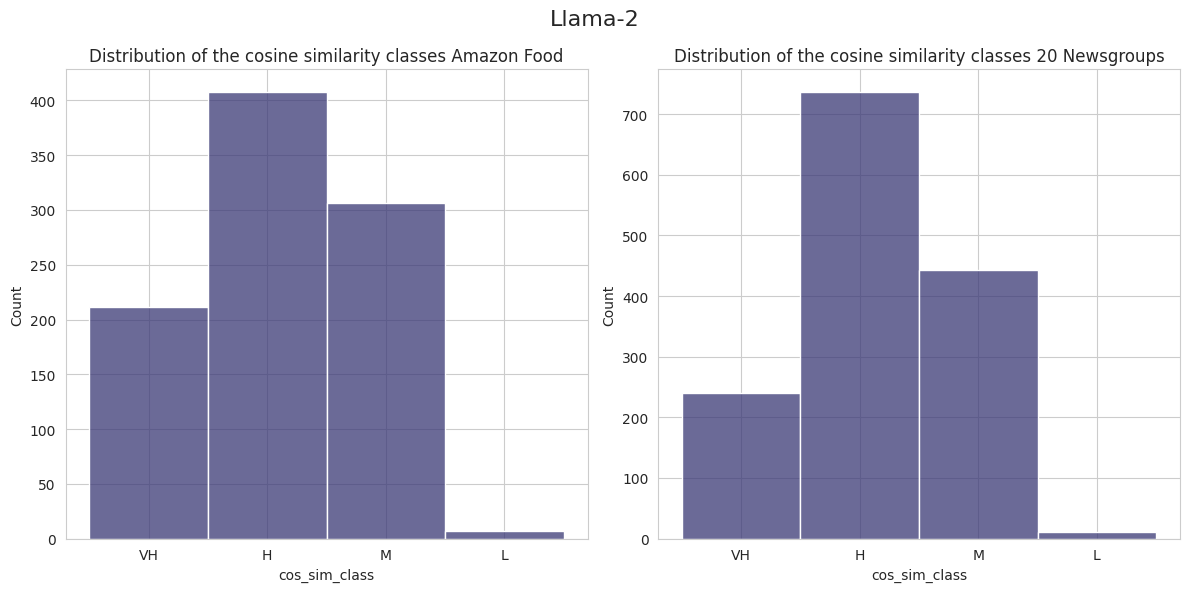

In [90]:
data_prompt_llama_2_amazon["cos_sim_class"] = pd.Categorical(
    data_prompt_llama_2_amazon['cos_sim_class'], 
    categories=['VH', 'H', 'M', 'L', 'VL'], ordered=True
)
data_prompt_llama_2_newsgroups["cos_sim_class"] = pd.Categorical(
    data_prompt_llama_2_newsgroups['cos_sim_class'], 
    categories=['VH', 'H', 'M', 'L', 'VL'], ordered=True
)

print_cos_sim_distrib(data_prompt_llama_2_amazon, data_prompt_llama_2_newsgroups, model_name="Llama-2")

In [273]:
grouped_cos_sim_amazon = data_prompt_llama_2_amazon['cos_sim_class'].value_counts().sort_index()
grouped_cos_sim_newsgroups = data_prompt_llama_2_newsgroups['cos_sim_class'].value_counts().sort_index()

In [274]:
print("Amazon_food:\n", grouped_cos_sim_amazon)
print("20newsgroups:\n", grouped_cos_sim_newsgroups)

Amazon_food:
 VH    211
H     408
M     306
L       7
VL      0
Name: cos_sim_class, dtype: int64
20newsgroups:
 VH    240
H     737
M     443
L      11
VL      0
Name: cos_sim_class, dtype: int64
